In [2]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats
import xarray as xr

HOURS = 10

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

test = torch.from_numpy(xr.open_dataset("test.nc").pr.values).reshape(-1, 1, HOURS, 64, 64)
# samples = torch.load("samples.pt", map_location=torch.device('cpu'))

In [3]:
def psd_temporal(frames, hours = HOURS):
    pixels_in_time = frames.reshape(frames.shape[0], hours, -1).transpose(1, 2).reshape(-1, hours)

    fourier_image = np.fft.fftn(pixels_in_time, axes = (1,))
    fourier_amplitudes = np.abs(fourier_image) ** 2

    kfreq = np.fft.fftfreq(hours) * hours
    knrm = np.abs(kfreq)

    kbins = np.arange(0.5, hours // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic( 
        knrm, # Need to check this
        fourier_amplitudes,
        statistic = "mean",
        bins = kbins
    )
    Abins = np.mean(Abins, axis = 0)

    return kvals, Abins

# kvals_test, Abins_test = psd_temporal(test)
# kvals_sample, Abins_sample = psd_temporal(samples)

# plt.figure(figsize=(6, 4))
# plt.loglog(kvals_test, Abins_test, label="UKCP18")
# plt.loglog(kvals_sample, Abins_sample, label="Generated")
# plt.xlabel("$k$")
# plt.ylabel("$P(k)$")
# plt.legend()
# plt.show()

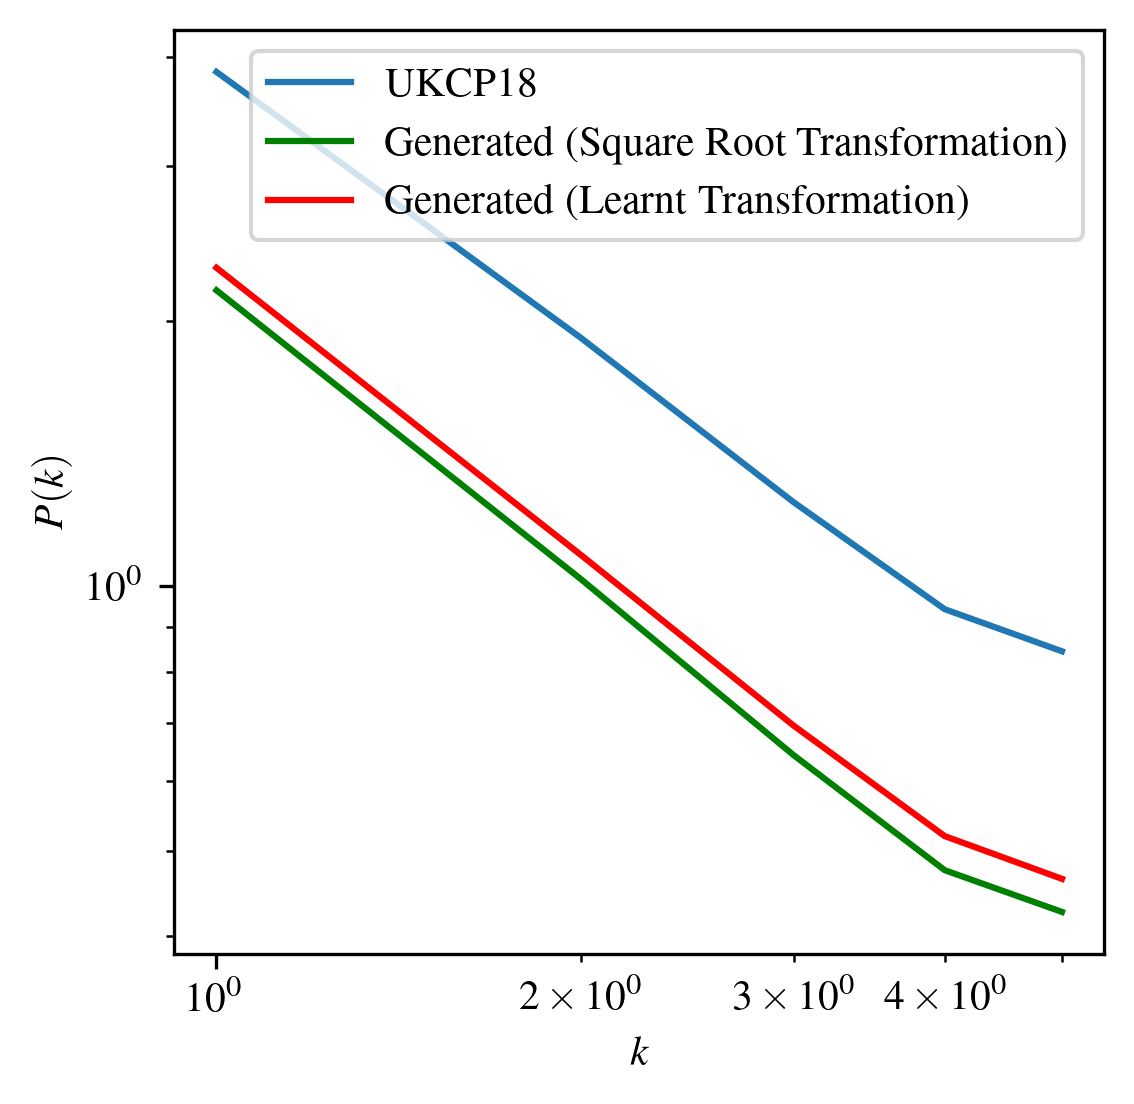

In [5]:
test = torch.from_numpy(xr.open_dataset("test.nc").pr.values).reshape(-1, 1, HOURS, 64, 64)
samples_sqrt = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu'))
sample_transform = torch.load(f"samples_transform_0.1.pt", map_location=torch.device('cpu'))

kvals_test, Abins_test = psd_temporal(test)
kvals_sample_sqrt, Abins_sample_sqrt = psd_temporal(samples_sqrt)
kvals_sample_transform, Abins_sample_transform = psd_temporal(sample_transform)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_sqrt, Abins_sample_sqrt, label="Generated (Square Root Transformation)", c = "green")
plt.loglog(kvals_sample_transform, Abins_sample_transform, label="Generated (Learnt Transformation)", c = "red")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_temporal.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

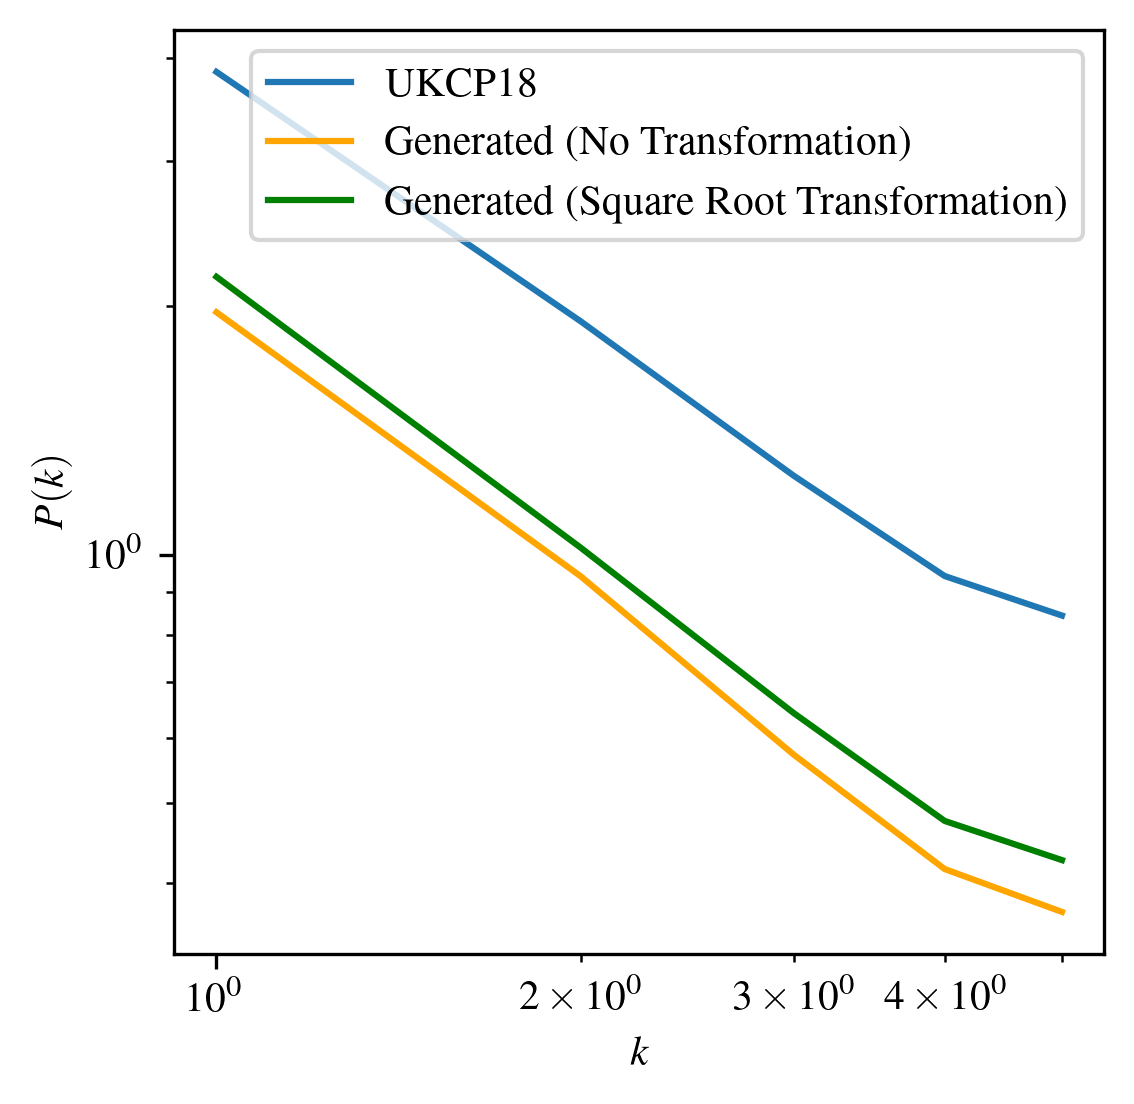

In [11]:
test = torch.from_numpy(xr.open_dataset("test.nc").pr.values).reshape(-1, 1, HOURS, 64, 64)
sample_no_transform = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu'))
samples_sqrt = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu'))

kvals_test, Abins_test = psd_temporal(test)
kvals_sample_no_transform, Abins_sample_no_transform = psd_temporal(sample_no_transform)
kvals_sample_sqrt, Abins_sample_sqrt = psd_temporal(samples_sqrt)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_no_transform, Abins_sample_no_transform, label="Generated (No Transformation)", c = "#ff7f0e")
plt.loglog(kvals_sample_sqrt, Abins_sample_sqrt, label="Generated (Square Root Transformation)", c = "green")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_temporal.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

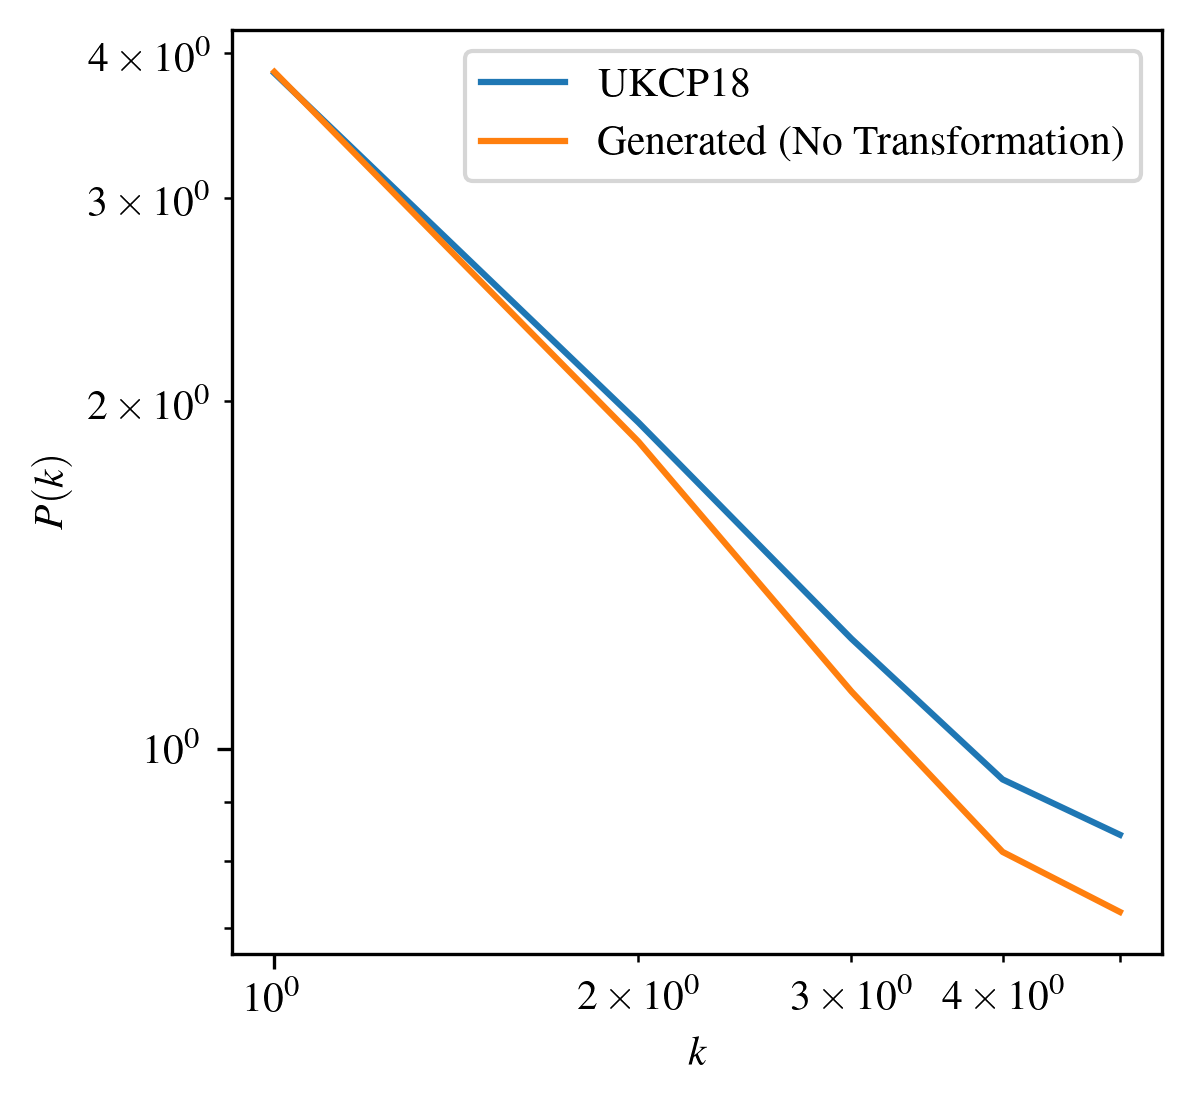

In [13]:
test = torch.from_numpy(xr.open_dataset("test.nc").pr.values).reshape(-1, 1, HOURS, 64, 64)
sample_no_transform = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')) * 1.4

kvals_test, Abins_test = psd_temporal(test)
kvals_sample_no_transform, Abins_sample_no_transform = psd_temporal(sample_no_transform)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_no_transform, Abins_sample_no_transform, label="Generated (No Transformation)", c = "#ff7f0e")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_temporal.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

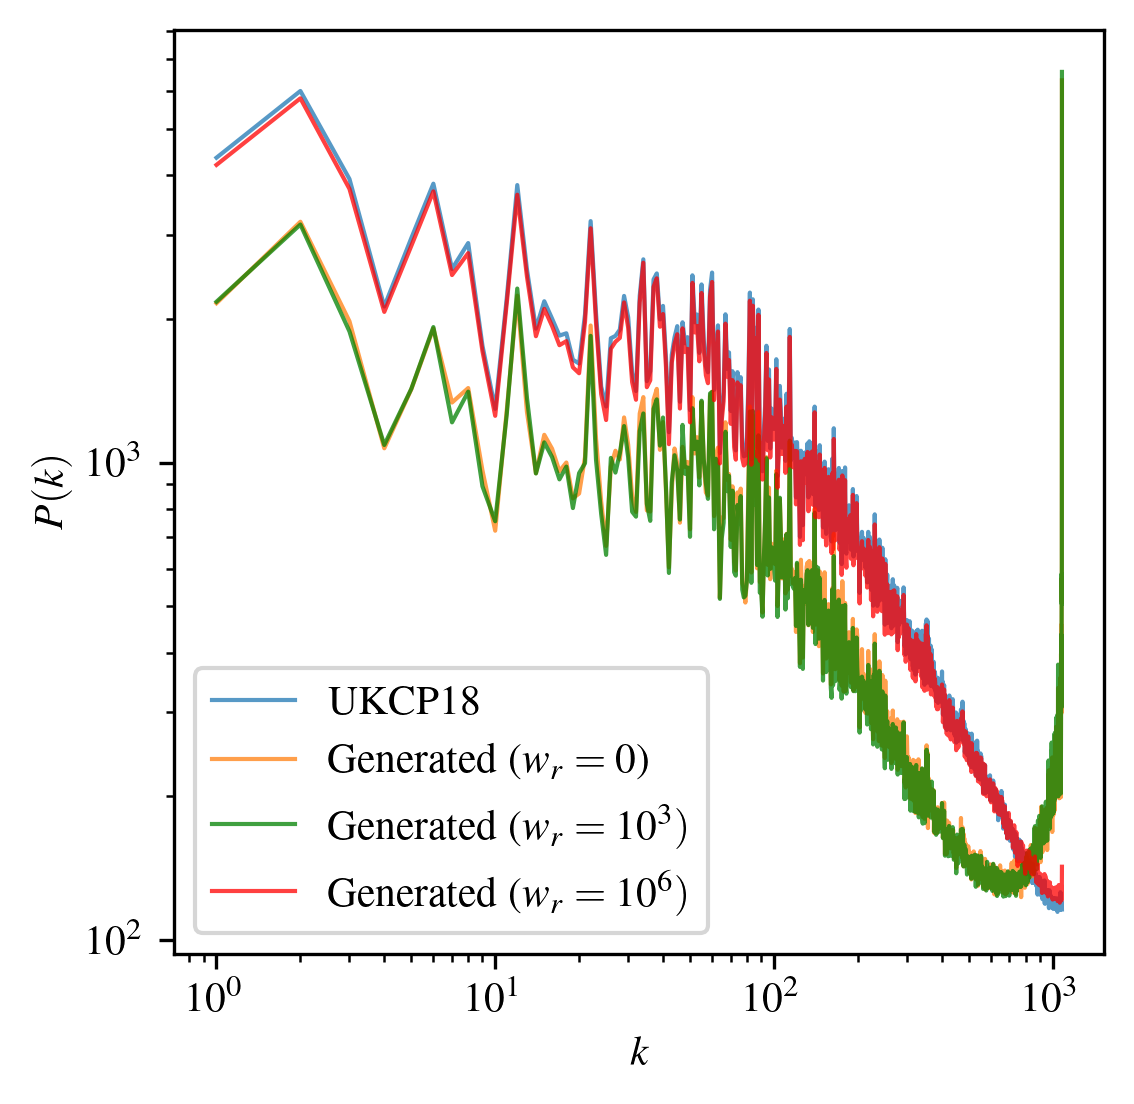

In [50]:
interpolate_0 = torch.load("cond_sample/cond_sample_recon_0.pt").reshape(-1, 1, 64, 64)
interpolate_1k = torch.load("cond_sample/cond_sample_recon_1000.pt").reshape(-1, 1, 64, 64)
interpolate_1m = torch.load("cond_sample/cond_sample.pt").reshape(-1, 1, 64, 64)

min_hours = min(interpolate_0.shape[0], interpolate_1k.shape[0], interpolate_1m.shape[0])
hours_in_season = int(360 / 4 * 24) 
num_seasons = min_hours // hours_in_season
num_hours = int(num_seasons * hours_in_season)

interpolate_0 = interpolate_0[:num_hours]
interpolate_1k = interpolate_1k[:num_hours]
interpolate_1m = interpolate_1m[:num_hours]

test = xr.open_dataset("test.nc").pr.isel(time = slice(0, num_hours)).values
test = test.reshape(-1, 1, 64, 64)
test = test[:num_hours]

interpolate_0 = interpolate_0.reshape(-1, 1, hours_in_season, 64, 64)
interpolate_1k = interpolate_1k.reshape(-1, 1, hours_in_season, 64, 64)
interpolate_1m = interpolate_1m.reshape(-1, 1, hours_in_season, 64, 64)
test = test.reshape(-1, 1, hours_in_season, 64, 64)
test = torch.from_numpy(test)

kvals_test, Abins_test = psd_temporal(test, hours = hours_in_season)
kvals_sample_interpolate_0, Abins_sample_interpolate_0 = psd_temporal(interpolate_0, hours = hours_in_season)
kvals_sample_interpolate_1k, Abins_sample_interpolate_1k = psd_temporal(interpolate_1k, hours = hours_in_season)
kvals_sample_interpolate_1m, Abins_sample_interpolate_1m = psd_temporal(interpolate_1m, hours = hours_in_season)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18", lw = 1, alpha = 0.75)
plt.loglog(kvals_sample_interpolate_0, Abins_sample_interpolate_0, label="Generated ($w_r = 0$)", c = "#ff7f0e", lw = 1, alpha = 0.75)
plt.loglog(kvals_sample_interpolate_1k, Abins_sample_interpolate_1k, label="Generated ($w_r = 10^{3})$", c = "green", lw = 1, alpha = 0.75)
plt.loglog(kvals_sample_interpolate_1m, Abins_sample_interpolate_1m, label="Generated ($w_r = 10^{6})$", c = "red", lw = 1, alpha = 0.75)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.show()
